In [24]:
import festim as F
import fenics as f
import numpy as np
import sympy as sp
from scipy import special
import sys

q_stat = 1e6  # float(sys.argv[1])
f_ELM = 0  # float(sys.argv[2])
E_ELM = 4700  # float(sys.argv[3])
eta_tr = 1e-4  # float(sys.argv[4])
Edt = 1.5  # float(sys.argv[5])

exposure_time = 1

# f_ELM = ${f_ELM}
# t_stop = ${time_exposure}

stat_params = {
    1e6: [51, 6.85e-1, 4.84e-1, 2.64e-9, 1.42e-9],
    5e6: [75, 6.66e-1, 4.61e-1, 3.27e-9, 1.76e-9],
    10e6: [97, 6.54e-1, 4.47e-1, 3.76e-9, 2.03e-9],
}

# q_stat = ${q_stat}
E_stat = stat_params[q_stat][0]
q = 1.6e-19
r_stat = stat_params[q_stat][1]
r_en_stat = stat_params[q_stat][2]
Te = E_stat / 4.85
htf = (4.85 * (1 - r_en_stat) + 2.15) * Te + 13.6
Gamma_stat = q_stat / htf / q
X_stat = stat_params[q_stat][3]
sigma_stat = stat_params[q_stat][4]

tau_IR = 250e-6
tau = 0.8 * tau_IR
n_eped = 8e19  # m^-3
W_plasma = 350e6  # J
alpha = 4.2  # degree
R_geo = 6.2  # m
P_sol = 100e6  # W/m^2
T_eped = 4.7e3  # eV
P_ELM = 0.3 * P_sol
if f_ELM > 0:
    dE_ELM = P_ELM / f_ELM / W_plasma
else:
    dE_ELM = 0
eps_long = (
    0.28
    * (n_eped / 1e20) ** 0.75
    * (T_eped / 1e3) ** 0.98
    * (dE_ELM * 100) ** 0.52
    * R_geo**1
    * 1e6
)
eps_trans = eps_long * np.sin(alpha * np.pi / 180)
q_elm_max = eps_trans / (
    tau**2 * f_ELM / 2 * sp.exp(-((tau * f_ELM) ** 2))
    + 3 / 4 * sp.sqrt(np.pi) * tau * (1 - special.erf(f_ELM * tau))
)

ELM_params = {
    4700: [3.82e-1, 1.99e-1, 4.34e-8, 2.32e-8],
    7050: [3.34e-1, 1.64e-1, 5.88e-8, 3.10e-8],
    9400: [2.98e-1, 1.40e-1, 7.34e-8, 3.82e-8],
    11750: [2.69e-1, 1.21e-1, 8.75e-8, 4.49e-8],
}

# E_ELM = ${E_ELM}
r_ELM = ELM_params[E_ELM][0]
r_en_ELM = ELM_params[E_ELM][1]
X_ELM = ELM_params[E_ELM][2]
sigma_ELM = ELM_params[E_ELM][3]

sigma = 5.67e-8
alpha_W = 0.4
T0 = 373.0

# eta_tr = ${eta_tr}
# Edt = ${Edt}


def thermal_cond_function(T):
    return (
        149.441
        - 45.466e-3 * T
        + 13.193e-6 * T**2
        - 1.484e-9 * T**3
        + 3.866e6 / (T + 1e-4) ** 2
    )


def heat_capacity_function(T):
    return (
        21.868372
        + 8.068661e-3 * T
        - 3.756196e-6 * T**2
        + 1.075862e-9 * T**3
        + 1.406637e4 / (T + 1.0) ** 2
    ) / 183.84e-3


def heat_of_transport(T):
    return -0.0045 * F.k_B * T**2


def rad(T, mobile):
    return -alpha_W * sigma * (T**4 - T0**4)


def cooling(T, mobile):
    if q_stat == 10e6:
        params = {  # "freq": q_eqv * (a + b*x+ c*exp(-d*x))
            0: [1.296e-1, 6.510e-3, 1.254e-1, np.log(0.87984)],
            10: [1.245e-1, 4.510e-3, 1.176e-1, np.log(0.9187)],
            20: [1.227e-1, 4.020e-3, 1.178e-1, np.log(0.92199)],
            30: [1.215e-1, 3.720e-3, 1.170e-1, np.log(0.9265)],
            40: [1.207e-1, 3.490e-3, 1.163e-1, np.log(0.93021)],
            50: [1.200e-1, 3.320e-3, 1.157e-1, np.log(0.93327)],
            60: [1.195e-1, 3.180e-3, 1.151e-1, np.log(0.93582)],
            70: [1.190e-1, 3.060e-3, 1.147e-1, np.log(0.93807)],
            80: [1.186e-1, 2.950e-3, 1.143e-1, np.log(0.94002)],
            90: [1.182e-1, 2.860e-3, 1.139e-1, np.log(0.94175)],
            100: [1.179e-1, 2.780e-3, 1.136e-1, np.log(0.94331)],
        }
    elif q_stat == 5e6:
        params = {  # "freq": q_eqv * (a + b*x+ c*exp(-d*x))
            0: [1.388e-1, 1.287e-2, 1.336e-1, np.log(7.922e-1)],
            10: [1.305e-1, 6.830e-3, 1.196e-1, np.log(8.852e-1)],
            20: [1.281e-1, 5.770e-3, 1.215e-1, np.log(8.949e-1)],
            30: [1.264e-1, 5.160e-3, 1.206e-1, np.log(9.033e-1)],
            40: [1.252e-1, 4.740e-3, 1.197e-1, np.log(9.097e-1)],
            50: [1.242e-1, 4.430e-3, 1.188e-1, np.log(9.147e-1)],
            60: [1.234e-1, 4.180e-3, 1.182e-1, np.log(9.188e-1)],
            70: [1.227e-1, 3.970e-3, 1.175e-1, np.log(9.223e-1)],
            80: [1.221e-1, 3.800e-3, 1.170e-1, np.log(9.253e-1)],
            90: [1.215e-1, 3.650e-3, 1.165e-1, np.log(9.278e-1)],
            100: [1.211e-1, 3.520e-3, 1.161e-1, np.log(9.300e-1)],
        }
    elif q_stat == 1e6:
        params = {  # "freq": q_eqv * (a + b*x+ c*exp(-d*x))
            0: [1.506e-1, 6.331e-2, 1.449e-1, np.log(3.523e-1)],
            10: [1.372e-1, 1.171e-2, 1.319e-1, np.log(7.864e-1)],
            20: [1.340e-1, 8.860e-3, 1.260e-1, np.log(8.476e-1)],
            30: [1.318e-1, 7.500e-3, 1.252e-1, np.log(8.672e-1)],
            40: [1.301e-1, 6.640e-3, 1.241e-1, np.log(8.799e-1)],
            50: [1.287e-1, 6.040e-3, 1.230e-1, np.log(8.889e-1)],
            60: [1.276e-1, 5.580e-3, 1.221e-1, np.log(8.960e-1)],
            70: [1.266e-1, 5.220e-3, 1.213e-1, np.log(9.016e-1)],
            80: [1.258e-1, 4.930e-3, 1.205e-1, np.log(9.064e-1)],
            90: [1.250e-1, 4.680e-3, 1.198e-1, np.log(9.104e-1)],
            100: [1.243e-1, 4.470e-3, 1.192e-1, np.log(9.138e-1)],
        }

    q_tot = q_stat
    if f_ELM > 0:
        q_tot += eps_trans * f_ELM

    return -q_tot * (
        params[f_ELM][0]
        + params[f_ELM][1] * (T - T0)
        - params[f_ELM][2] * f.exp(params[f_ELM][3] * (T - T0))
    )


def norm_flux(X, sigma):
    L = 6e-3
    return 2 / (
        special.erf((L - X) / np.sqrt(2) / sigma)
        + special.erf((X) / np.sqrt(2) / sigma)
    )


w_atom_density = 6.31e28  # atom/m3

my_model = F.Simulation(log_level=40)

r = 1.0188
N = 750
width = 0.1e-9

mesh = [0]
for i in range(1, N):
    mesh.append(mesh[-1] + width * r ** (i - 1))
mesh[-1] = 6e-3
vertices = np.array(mesh)

my_model.mesh = F.MeshFromVertices(vertices=vertices)

tungsten = F.Material(
    id=1,
    D_0=1.93e-7 / np.sqrt(2),
    E_D=0.2,
    thermal_cond=thermal_cond_function,
    heat_capacity=heat_capacity_function,
    rho=19250,
    Q=heat_of_transport,
)

my_model.materials = tungsten

trap = F.Trap(
    k_0=1.93e-7 / (1.1e-10**2 * 6 * w_atom_density) / np.sqrt(2),
    E_k=0.2,
    p_0=1e13,
    E_p=Edt,
    density=eta_tr * w_atom_density,
    materials=tungsten,
)

my_model.traps = [trap]

stat_source = F.ImplantationFlux(
    flux=Gamma_stat * (1 - r_stat) * norm_flux(X_stat, sigma_stat),  # H/m2/s
    imp_depth=X_stat,  # m
    width=sigma_stat,  # m
    volume=1,
)

my_model.boundary_conditions = [
    F.FluxBC(value=q_stat, field="T", surfaces=1),
    F.CustomFlux(function=rad, field="T", surfaces=1),
    F.CustomFlux(function=cooling, field="T", surfaces=2),
    F.DirichletBC(surfaces=[1, 2], value=0, field=0),
]

my_model.sources = [stat_source]
if f_ELM > 0:

    def q_ELM(t):
        t1 = t % (1 / f_ELM)
        return (
            q_elm_max
            * (1 + (tau / t1) ** 2)
            * (tau / t1) ** 2
            * sp.exp(-((tau / t1) ** 2))
        )

    def flux_elm(t):
        t1 = t % (1 / f_ELM)
        return (
            q_elm_max
            * (tau / t1) ** 2
            * sp.exp(-((tau / t1) ** 2))
            / T_eped
            / (1 - r_en_ELM)
            / q
        )

    elm_source = F.ImplantationFlux(
        flux=flux_elm(F.t) * (1 - r_ELM) * norm_flux(X_ELM, sigma_ELM),  # H/m2/s
        imp_depth=X_ELM,  # m
        width=sigma_ELM,  # m
        volume=1,
    )

    my_model.sources.append(elm_source)
    my_model.boundary_conditions.append(
        F.FluxBC(value=q_ELM(F.t), field="T", surfaces=1)
    )

absolute_tolerance_T = 1.0
relative_tolerance_T = 1e-4
absolute_tolerance_c = 1e10
relative_tolerance_c = 1e-8
max_iter = 500

my_model.T = F.HeatTransferProblem(
    absolute_tolerance=absolute_tolerance_T,
    relative_tolerance=relative_tolerance_T,
    initial_condition=F.InitialCondition(field="T", value=T0),
    maximum_iterations=max_iter,
)


def stepsize(t):
    if t <= exposure_time and f_ELM > 0:
        CYCLE_TIME = 1 / f_ELM
        ELM_TIME = 2.5e-3
        max_stepsize_during_elm = 5e-6
        if (t + 3 * float(my_model.dt.value)) % CYCLE_TIME < ELM_TIME:
            return max_stepsize_during_elm
        else:
            return 1e-3
    else:
        return 1


my_model.dt = F.Stepsize(
    initial_value=1e-6, stepsize_change_ratio=1.1, max_stepsize=stepsize, dt_min=1e-8
)

my_model.settings = F.Settings(
    absolute_tolerance=absolute_tolerance_c,
    relative_tolerance=relative_tolerance_c,
    final_time=exposure_time,
    soret=True,
    maximum_iterations=max_iter,
)


class CustomDerivedQuantities(F.DerivedQuantities):
    def compute(self, t):
        row = [t]
        for quantity in self:
            if isinstance(quantity, (F.MaximumVolume, F.MinimumVolume)):
                value = quantity.compute(self.volume_markers)
            elif isinstance(quantity, RecyclingCoefficient):
                value = quantity.compute(t)
            else:
                value = quantity.compute()

            # check if first time writing data
            if len(self.data) == 0:
                self.data = [self.make_header()]

            quantity.data.append(value)
            quantity.t.append(t)
            row.append(value)
        self.data.append(row)
        self.t.append(t)


class RecyclingCoefficient(F.HydrogenFlux):
    def __init__(self, surface) -> None:
        super().__init__(surface)

    @property
    def title(self):
        quantity_title = "Recycling coefficient at surface {}".format(self.surface)
        if self.show_units:
            return quantity_title + f" ({self.export_unit})"
        else:
            return quantity_title

    @property
    def export_unit(self):
        return ""

    def compute(self, time):
        des_flux = np.abs(super().compute())
        impl_flux = 0
        t = sp.Symbol("t")
        for source in my_model.sources:
            if isinstance(source.flux, sp.Expr):
                impl_flux += source.flux.subs(t, time) / norm_flux(X_ELM, sigma_ELM)
            else:
                impl_flux += source.flux / norm_flux(X_stat, sigma_stat)
        return des_flux / impl_flux


derived_quantities = [
    CustomDerivedQuantities(
        [
            F.HydrogenFlux(surface=1),
            F.TotalSurface(field="T", surface=1),
            F.TotalVolume(field="retention", volume=1),
            F.TotalVolume(field="solute", volume=1),
            F.TotalVolume(field="1", volume=1),
            RecyclingCoefficient(surface=1),
        ],
        nb_iterations_between_compute=1,
        show_units=True,
        filename="./results/derived_quantities_exposure.csv",
    )
]


my_model.exports = derived_quantities

my_model.initialise()
my_model.run()


Defining variational problem heat transfers
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+00 s    Elapsed time so far: 8.8 s


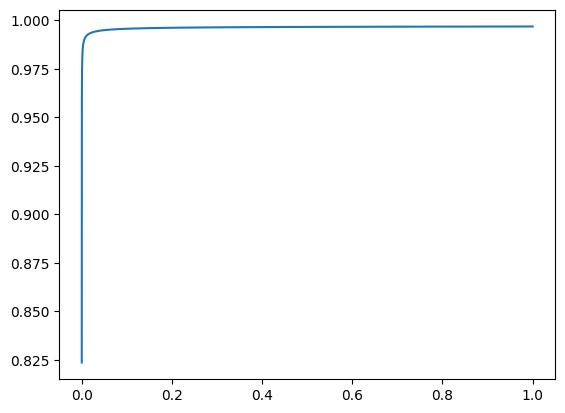

In [25]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("./results/derived_quantities_exposure.csv", skiprows=1, delimiter=",")

plt.plot(data[:,0], data[:,-1])
# plt.xlim(0.1975, 0.205)
# plt.ylim(0.8, 1.1)
plt.show()

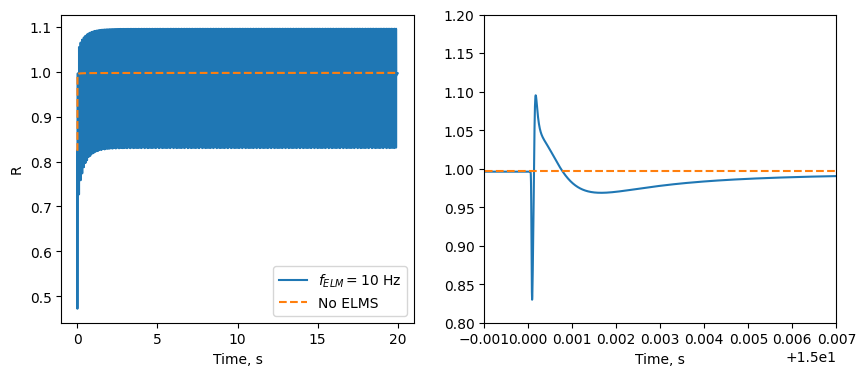

In [48]:
import numpy as np
import matplotlib.pyplot as plt

data_stat = np.loadtxt("./ELM_1228269_23_0Hz_1e6MW_1.5eV_1e-4/results/derived_quantities_exposure.csv", skiprows=1, delimiter=",")
data_ELM = np.loadtxt("./ELM_1228269_24_10Hz_1e6MW_1.5eV_1e-4/results/derived_quantities_exposure.csv", skiprows=1, delimiter=",")

fig, axs = plt.subplots(1,2, figsize=(10,4))

axs[0].plot(data_ELM[:,0], data_ELM[:,-1], label=r"$f_{ELM}=10$ Hz")
axs[0].plot(data_stat[:,0], data_stat[:,-1], label="No ELMS", ls="dashed")

axs[1].plot(data_ELM[:,0], data_ELM[:,-1], label=r"$f_{ELM}=10$ Hz")
axs[1].plot(data_stat[:,0], data_stat[:,-1], label="No ELMS", ls="dashed")

axs[1].set_ylim(0.8, 1.2)
axs[1].set_xlim(14.999, 15.007)

axs[0].set_ylabel("R")
axs[0].set_xlabel("Time, s")
axs[1].set_xlabel("Time, s")
axs[0].legend()
# plt.xlim(0.1975, 0.205)
# plt.ylim(0.8, 1.1)
plt.show()